<h1>SM-NUMBA-SINTEL-convolved
</h1><br>


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd "gdrive/My Drive/python_projects/FYP"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/python_projects/FYP


In [0]:
# built in modules and libraries

import numpy as np
import importlib as imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
import math
import time
import glob

# Custom libraries/classes

from components.classes.NumbaSimpleMatcher import Wrapper as Matcher

from components.classes.Metrix import Wrapper as Metrix
from components.classes.SintelReader import Wrapper as SintelReader
from components.classes.CSVReader import Wrapper as CSVReader
from components.classes.CSVWriter2 import Wrapper as CSVWriter



# singleton class: we will only have one progress bar
from components.classes.SimpleProgressBar import SimpleProgressBar


# Custom libraries/utils

from components.utils import plot_utils as plu
from components.utils import utils as u

##Configuring and testing data generator

File ./optimization/final//numba_sm/SM_VGG16_v5_GC_8p_64_240_1024.csv already exists, header has not been written.


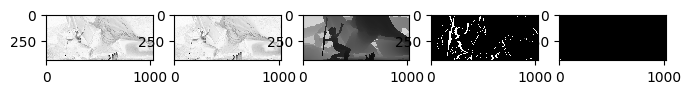

In [5]:
##################################################################################
# Setting default parameters  #################################################### 
##################################################################################
NUM_PROC = 64

LOG_OUTPUT_ROOT = "./optimization/final/"

LOG_DIRECTORY = LOG_OUTPUT_ROOT+"/numba_sm/"

SPEC_MARKER = "SM_VGG16_v5_GC_8p_64_240_1024"

CSV_FILE_NAME =  SPEC_MARKER+".csv"

CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)

##################################################################################
# Instantiating reader and csv writer ############################################
##################################################################################


STEREO_IMGS_ROOT = "./datasets/sintel/training"

IMG_READER = SintelReader(rootPath=STEREO_IMGS_ROOT)

CSV_WRITER = CSVWriter(file_path = CSV_FILE_PATH)

PROGRESS_VIEWER = SimpleProgressBar.get_instance()

NUM_SCENES = len(IMG_READER.get_available_scenes())

SCENE_STEP=2

##################################################################################
# Testing reader configuration ###################################################
##################################################################################
## CSV writer should output if there has been a permission error or file already exists (which is not a problem)

IMG_READER.set_selected_scene('cave_4')

loaded_imgs = IMG_READER.get_selected_scene_next_files()

IMG_READER.plot_images_to_compare(loaded_imgs)


In [0]:
##################################################################################
# SPEC_DICT: columns that will be written to csv##################################
##################################################################################

SPEC_DICT = dict({})

SPEC_DICT["is_parallel"] = "True"

SPEC_DICT["alg_type"] =  SPEC_MARKER
SPEC_DICT["is_img_preprocessed"] = "yes"



SPEC_DICT["filter_strategy"] = "VGG16_one_by_one"
SPEC_DICT["matching_mode"] =  "occlusions_added_to_the_groundtruth"
SPEC_DICT["matrix_init_mode"] = 2

# Have to be updated iteratively
SPEC_DICT["img_name_pretag"] = SPEC_MARKER+"_SCENE_"
SPEC_DICT["img_name"] = "Non-defined"
SPEC_DICT["convolution_filters"] = "-1"

In [7]:
##################################################################################
# Making sure that Tensorflow session is placed on the GPU, if available #########
##################################################################################
"""
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5000),
          tf.config.LogicalDeviceConfiguration(memory_limit=5000)])

    logical_devices = tf.config.list_logical_devices('GPU')
    assert len(logical_devices) == len(physical_devices) + 1

    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5000),
          tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
except:
    # Invalid device or cannot modify logical devices once initialized.
    pass"""

"\nimport tensorflow as tf\n\nphysical_devices = tf.config.list_physical_devices('GPU')\nprint(physical_devices)\ntry:\n    tf.config.set_logical_device_configuration(\n        physical_devices[0],\n        [tf.config.LogicalDeviceConfiguration(memory_limit=5000),\n          tf.config.LogicalDeviceConfiguration(memory_limit=5000)])\n\n    logical_devices = tf.config.list_logical_devices('GPU')\n    assert len(logical_devices) == len(physical_devices) + 1\n\n    tf.config.set_logical_device_configuration(\n        physical_devices[0],\n        [tf.config.LogicalDeviceConfiguration(memory_limit=5000),\n          tf.config.LogicalDeviceConfiguration(memory_limit=5000)])\nexcept:\n    # Invalid device or cannot modify logical devices once initialized.\n    pass"

In [8]:
##################################################################################
# Currently supported models: see tf_utils.py in components/utils ################
##################################################################################

from components.utils import tf_utils as tfu

##################################################################################
# Specifying IMG Dimensions for the model#########################################
##################################################################################

WIDTH = 1024
HEIGHT = 240
IMG_DIM_FOR_MODEL = [HEIGHT,WIDTH, 3]


##################################################################################
# Getting the "first-layer" model ################################################
##################################################################################

MODEL = tfu.get_vgg16_first_layer_model(IMG_DIM_FOR_MODEL)
MODEL.summary()

##################################################################################
# Uncomment the line below to check model configuration ##########################
##################################################################################

#model.get_config()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 1024, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [9]:
##################################################################################
# PRE-PROCESSING IMAGES: first image in each scene ###############################
## CAVEAT :FAST-EXECUTION BUT LOADS OF STORAGE SPACE: RUN IT EVERY TIME ... ######
## ... if new execution environment: exclude them from GIT push    ###############
##################################################################################

PREPROCESS_IMGS_DIRECTORY = "./optimization/pickled_slice_predictions/vgg16/"

IMG_READER.convolve_slices_and_save(MODEL,  slice_height = HEIGHT, slice_width = WIDTH, output_directory=PREPROCESS_IMGS_DIRECTORY)


Writing file ./optimization/pickled_slice_predictions/vgg16/shaman_2_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/cave_4_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/shaman_3_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/sleeping_1_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/market_2_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/alley_1_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/sleeping_2_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/alley_2_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/ambush_2_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predictions/vgg16/ambush_4_im-0-lr_w-1024_h-240_sr-0
Writing file ./optimization/pickled_slice_predicti

Found images: 23
Each image's shape: (2, 240, 1024, 64)


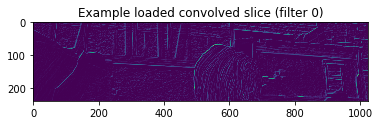

In [10]:
##################################################################################
# LOADING the preprocess images: one for each scene ##############################
##################################################################################

PREPROCESSED_PICKLES = IMG_READER.list_pickled_convolved(PREPROCESS_IMGS_DIRECTORY, WIDTH, HEIGHT)

PREPROCESSED_PICKLES = sorted(PREPROCESSED_PICKLES)

##################################################################################
# TESTING LOADED IMAGES VISUALLY #################################################
##################################################################################

one_pickle = IMG_READER.load_pickled_convolved(PREPROCESSED_PICKLES[0])
selected_filter_index = 0

print("Found images: {0}".format(len(PREPROCESSED_PICKLES)))
print("Each image's shape: {0}".format(one_pickle.shape))

fig = plt.figure()
ax = fig.gca()

ax.set_title("Example loaded convolved slice (filter {0})".format(selected_filter_index))
plt.imshow(one_pickle[0, :, :, selected_filter_index])


##Initialising loop parameters

In [0]:
##################################################################################
# Uncomment to see available scnenes #############################################
##################################################################################

#SCENES = reader.get_available_scenes()
#SCENES = sorted(SCENES)
#print(SCENES)

##################################################################################
# LOADING Grountruth images: only 23, can be loaded into memory###################
##################################################################################

STARTING_ROW_FOR_SLICES = 0
ALL_DISPARITIES = IMG_READER.get_all_sliced_disparities(HEIGHT, WIDTH, STARTING_ROW_FOR_SLICES = STARTING_ROW_FOR_SLICES)


In [0]:
##################################################################################
# GETTING N BEST PARAMETERS FROM THE SELECTED FILE ###############################
##################################################################################

SELECTED_CSV_FILE_PATH = "./optimization/final/numba_legacy/legacy_mixed_lines.csv"
CSV_READER = CSVReader(SELECTED_CSV_FILE_PATH)
CSV_FILE_DESCRIPTION = CSV_READER.get_description()

#print(CSV_FILE_DESCRIPTION)

In [13]:
top_n_config = []

n = 3

selected_metric = "ABS_ERR"

res = CSV_READER.get_best_n_params(n, selected_metric)
top_n_config.append(res)

selected_metric = "mse"

res = CSV_READER.get_best_n_params(n, selected_metric)
top_n_config.append(res)

selected_metric = "euclid_distance"

res = CSV_READER.get_best_n_params(n, selected_metric)
top_n_config.append(res)

top_n_config.append([60, -20, -1, 0])
LOADED_BEST_PARAMS = np.vstack(top_n_config)
print(LOADED_BEST_PARAMS.shape[0])
#print("Please enter the estimated runtime per images in seconds below:")

runtime_multiplyer = (6)
#runtime_multiplyer = input()

10


In [14]:
NUMBER_OF_ITERATIONS = len(LOADED_BEST_PARAMS)  * NUM_SCENES *64/SCENE_STEP
est_runtime = int(NUMBER_OF_ITERATIONS) * float(runtime_multiplyer)
print("Filters tried/per iteration: {0}/64".format(NUM_PROC))
print("The number of iterations based on the params: {0}".format(round(NUMBER_OF_ITERATIONS)))
print("The amount of time (s) needed to perform the parameter search: {0}".format(est_runtime))
print("The amount of time (h) needed to perform the parameter search: {0}".format(est_runtime/3600))

Filters tried/per iteration: 64/64
The number of iterations based on the params: 7360
The amount of time (s) needed to perform the parameter search: 44160.0
The amount of time (h) needed to perform the parameter search: 12.266666666666667


In [15]:
from components.classes import SintelThreadProvider as STP
import importlib
importlib.reload(STP)
q = STP.Queue(5)
pickled_file_list = [] #todo here
dataLoaderThread = STP.SintelThreadProvider(name="data_provider_1", queue=q, fileList = PREPROCESSED_PICKLES, scene_step=SCENE_STEP)
dataLoaderThread.start()

while(not dataLoaderThread.isReady()):
    time.sleep(1)
print("Queue has been filled up.")
gts = [SintelReader.add_masks_to_raw_disparity(ALL_DISPARITIES[i, 0], ALL_DISPARITIES[i, 1], ALL_DISPARITIES[i, 2]) for i in (range(ALL_DISPARITIES.shape[0]))]



Queue has been filled up.


In [0]:
NEXT_IMAGE = q.pop()
OUTER_LOOP_COUNTER = 0
INTERNAL_LOOP_COUNTER = 0

import logging
logging.basicConfig(level=logging.WARNING,
                    format='(%(threadName)-9s) %(message)s', )

In [0]:
def matcher_queue(filter_index):
    global PROGRESS_VIEWER
    global NUMBER_OF_ITERATIONS
    global CSV_WRITER
    global SPEC_DICT
    global NEXT_IMAGE
    global CURRENT_GROUNDTRUTH
    global semaphore
    SPEC_DICT =SPEC_DICT.copy()
 
    leftee = NEXT_IMAGE[filter_index, 0]
    rightee = NEXT_IMAGE[filter_index, 1]

    SPEC_DICT["convolution_filters"] = str(filter_index)

    matcher = Matcher(SPEC_DICT["match"], SPEC_DICT["gap"], SPEC_DICT["egap"])
    matcher.configure_instance()
    matcher.set_images(rightee, leftee)
    tic=time.time()

    x,raw_disp_map = matcher.run_pipeline()

    toc = time.time()

    SPEC_DICT["runtime"] = toc-tic

    SPEC_DICT["mse"] = Metrix.mse(raw_disp_map, CURRENT_GROUNDTRUTH)

    SPEC_DICT["euclid_distance"] =Metrix.eucledian_distance(raw_disp_map, CURRENT_GROUNDTRUTH)

    SPEC_DICT["ABS_ERR"] = Metrix.avgerr(raw_disp_map, CURRENT_GROUNDTRUTH, print=False)
    semaphore.acquire()
    CSV_WRITER.append_new_sm_results(SPEC_DICT)
    semaphore.release()

In [0]:
def init(l):
    global lock
    lock = l

In [0]:
import multiprocessing.pool

semaphore =  multiprocessing.Lock()

while(NEXT_IMAGE is not None):
    
    CURRENT_GROUNDTRUTH = gts[OUTER_LOOP_COUNTER]
    
    SPEC_DICT["img_name"] = SPEC_DICT["img_name_pretag"]+str(OUTER_LOOP_COUNTER*2)

    OUTER_LOOP_COUNTER+=1
    
    for best_params in LOADED_BEST_PARAMS:
        match = SPEC_DICT["match"] = best_params[0]
        gap = SPEC_DICT["gap"] = best_params[1]
        egap = SPEC_DICT["egap"] = best_params[2]

        filter_range = [i for i in range(64)]
        with multiprocessing.Pool(NUM_PROC) as pool:
            r = pool.map(matcher_queue, filter_range)
        pool.terminate()
        pool.join()
        INTERNAL_LOOP_COUNTER+=64
        PROGRESS_VIEWER.progress_bar(INTERNAL_LOOP_COUNTER, NUMBER_OF_ITERATIONS, header= "Parameter search progress: ", progress_bar_steps=100)   

            #pool.join()
    NEXT_IMAGE = q.pop()
    
end_time = time.time()
print("The optimisation process taken {0} seconds or {1} hours".format((end_time-start_time), (end_time-start_time)/3600))

##Running the optimisation